In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from bs_fdbck.constants import path_extract_latlon_outdata
from dask.diagnostics import ProgressBar
import seaborn as sns

from bs_fdbck.util.imports import import_fields_xr_echam

import pandas as pd



from bs_fdbck.constants import path_measurement_data

from bs_fdbck.util.BSOA_datamanip import compute_total_tau, broadcase_station_data, change_units_and_compute_vars, \
    get_dic_df_mod, change_units_and_compute_vars_echam,extract_2D_cloud_time_echam, rn_dic_echam_cloud, rn_dic_noresm_cloud

import datetime

from bs_fdbck.util.BSOA_datamanip import fix_echam_time

 from pathlib import Path 
 Path(path).mkdir(exist_ok=True, parents=True)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/data_info/area_defs.csv


In [3]:
xr.set_options(keep_attrs=True) 

In [4]:
rn_dic_echam = {
    'cwp'      : 'CWP',
    'cod'      : 'COT',
    'ceff_ct'  : 'r_eff',


}
rn_dic_noresm = {
    'TGCLDCWP_incld'         : 'CWP',
    'TOT_CLD_VISTAU_s_incld': 'COT',
    'ACTREL_incld'     : 'r_eff',
}
rn_dic_obs = {
    'CWP (g m^-2)'        : 'CWP',
    'CER (micrometer)'    : 'r_eff',
    'OA (microgram m^-3)' : 'OA',

}



## NorESM

In [5]:
lon_lims = [22.,30.]
lat_lims = [60.,66.]

lat_smr = 61.85
lon_smr = 24.28
model_lev_i=-1

temperature = 273.15  # K


from_time1 = '2012-01-01'
to_time1 = '2015-01-01'
from_time2 ='2015-01-01'
to_time2 ='2019-01-01'

In [6]:
case_name = 'OsloAero_intBVOC_f09_f09_mg17_fssp245'

case_name1 = 'OsloAero_intBVOC_f09_f09_mg17_full'
case_name2 = 'OsloAero_intBVOC_f09_f09_mg17_ssp245'

In [7]:
cases = [case_name]

### Path input data

In [8]:

path_input_data_noresm = path_extract_latlon_outdata/ case_name

### Filenames

In [9]:
fn1   = path_extract_latlon_outdata/case_name1/f'{case_name1}.h1._{from_time1}-{to_time1}_concat_subs_22.0-30.0_60.0-66.0.nc'

fn1_2 = fn1.parent / f'{fn1.stem}_sort.nc'

fn2   = path_extract_latlon_outdata/case_name2 /f'{case_name2}.h1._{from_time2}-{to_time2}_concat_subs_22.0-30.0_60.0-66.0.nc'

fn2_2 = fn2.parent / f'{fn2.stem}_sort.nc'

fn_comb                = path_input_data_noresm /f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_22.0-30.0_60.0-66.0.nc'
fn_comb_lev1           = path_input_data_noresm /f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_22.0-30.0_60.0-66.0_lev1.nc'
fn_comb_lev1_final     = path_input_data_noresm /f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_22.0-30.0_60.0-66.0_lev1_final.nc'
fn_comb_lev1_final_csv = path_input_data_noresm /f'{case_name}.h1._{from_time1}-{to_time2}_concat_subs_22.0-30.0_60.0-66.0_lev1_final.csv'

### Station variables

In [10]:
varl_st = [      'SOA_NA','SOA_A1','OM_NI','OM_AI','OM_AC','SO4_NA','SO4_A1','SO4_A2','SO4_AC','SO4_PR',
      'BC_N','BC_AX','BC_NI','BC_A','BC_AI','BC_AC','SS_A1','SS_A2','SS_A3','DST_A2','DST_A3',
                 ]


varl_cl = ['TOT_CLD_VISTAU','TOT_ICLD_VISTAU','TGCLDCWP','TGCLDLWP','TGCLDIWP',
           'TOT_CLD_VISTAU_s','TOT_ICLD_VISTAU_s','optical_depth',
           'CLDFREE',
           'FCTL',
           'ACTREL','ACTNL','TGCLDLWP',
           'FSDSC','FSDSCDRF',
           'FCTI',
           'FCTL',
           'FLNS',
           'FLNSC',
           'FLNT',
           'FLNTCDRF',
           'FLNT_DRF',
           'FLUS',
           'FLUTC','FORMRATE',
           'FREQI',
           'FREQL',
           'FSDSCDRF',
           'FSDS_DRF',
           'FSNS',
           'FSNSC',
           'FSNT',
           'FSNTCDRF',
           'FSNT_DRF',
           'FSUS_DRF',
           'FSUTADRF',
           ]

### Read files and compute vertical variables, extract surface layer,  and merge timeseries

In [11]:
fn_comb#.exists()

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/OsloAero_intBVOC_f09_f09_mg17_fssp245/OsloAero_intBVOC_f09_f09_mg17_fssp245.h1._2012-01-01-2019-01-01_concat_subs_22.0-30.0_60.0-66.0.nc')

In [12]:
if not fn_comb.exists():
    if (not fn1_2.exists()) or (not fn2_2.exists()):
        ds_mod1 = xr.open_dataset(fn1, chunks = {'time':96})#[fn1,fn2])#.sortby('time')
        ds_mod2 = xr.open_dataset(fn2, chunks = {'time':96})

        varl1 = set(ds_mod1.data_vars)

        varl2 = set(ds_mod2.data_vars)


        varl =list(varl1.intersection(varl2))

        ds_mod1 = ds_mod1[varl].sel(time=slice(sel_years_from_files[0],sel_years_from_files[1]))#.sortby('time')

        ds_mod2 = ds_mod2[varl].sel(time=slice(sel_years_from_files[2],sel_years_from_files[3]))#.sortby('time')
        print('HEEEEY')
        if not fn1_2.exists():
            delayed_obj = ds_mod1.to_netcdf(fn1_2, compute=False)
            with ProgressBar():
                results = delayed_obj.compute()
        if not fn2_2.exists():
            delayed_obj = ds_mod2.to_netcdf(fn2_2, compute=False)
            with ProgressBar():
                results = delayed_obj.compute()
    
    if not fn1_3.exists():
            ds_mod1 = xr.open_dataset(fn1_2, chunks = {'time':48})#[fn1,fn2])#.sortby('time')
            ds_mod1 = compute_total_tau(ds_mod1)
            ds_mod1 = ds_mod1.isel(lev = model_lev_i)
            ds_mod1 = ds_mod1.sortby('time')#.sel(time=slice('2012','2014'))
            delayed_obj = ds_mod1.to_netcdf(fn1_3, compute=False)
            print('hey 1')
            with ProgressBar():
                results = delayed_obj.compute()
    if not fn2_3.exists():
            ds_mod2 = xr.open_dataset(fn2_2, chunks = {'time':48})#[fn1,fn2])#.sortby('time')
            ds_mod2 = compute_total_tau(ds_mod2)
            ds_mod2 = ds_mod2.isel(lev = model_lev_i)
            ds_mod2 = ds_mod2.sortby('time')#.sel(time=slice('2012','2014'))
            delayed_obj = ds_mod2.to_netcdf(fn2_3, compute=False)
            print('hey')
            with ProgressBar():
                results = delayed_obj.compute()
    
    
    ds_mod = xr.open_mfdataset([fn1_3,fn2_3], combine='by_coords', concat_dim='time')

    fn_comb.parent.mkdir(exist_ok=True,)

    delayed_obj = ds_mod.to_netcdf(fn_comb, compute = False)
    with ProgressBar():
        results = delayed_obj.compute()

    #ds_mod = xr.concat([ds_mod1[varl].sel(time=slice('2012','2014')), ds_mod2[varl].sel(time=slice('2015','2018'))], dim='time')

### Check: 

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'rasterio' loading failed:
(click 8.0.1 (/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages), Requirement.parse('click<8,>=4.0'), {'rasterio'})
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


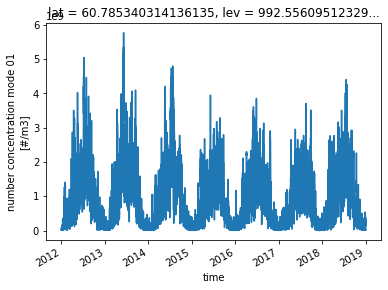

In [13]:
ds_mod = xr.open_dataset(fn_comb, chunks = {'time':48})
ds_mod['NCONC01'].isel(lat=0, lon=0).plot()

### Broadcast station variables to every gridcell and manipulate units etc

We use only hyytiala for org etc, but all grid cells over finland for cloud properties

In [14]:
fn_comb_lev1_final

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/OsloAero_intBVOC_f09_f09_mg17_fssp245/OsloAero_intBVOC_f09_f09_mg17_fssp245.h1._2012-01-01-2019-01-01_concat_subs_22.0-30.0_60.0-66.0_lev1_final.nc')

In [15]:
if not fn_comb_lev1_final.exists():
    ds_all = xr.open_dataset(fn_comb).isel(ilev=model_lev_i)
    ds_sel = ds_all.sel(lat = lat_smr, lon= lon_smr, method='nearest')#.isel( ilev=model_lev_i)#.load()
    ds_all = ds_all.isel(
             nbnd=0
    ).squeeze()
    ds_all = broadcase_station_data(ds_all)
    ds_all = change_units_and_compute_vars(ds_all, temperature=temperature)


    delayed_obj = ds_all.to_netcdf(fn_comb_lev1_final, compute=False)
    print('hey')
    with ProgressBar():
        results = delayed_obj.compute()

In [16]:
fn_comb_lev1.exists()

True

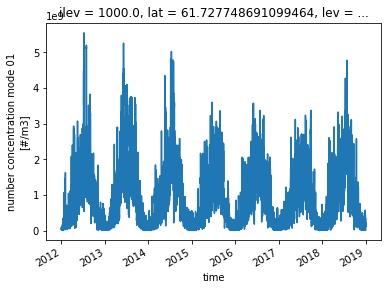

In [17]:

ds_all = xr.open_dataset(fn_comb_lev1_final)

ds_all['NCONC01'].isel(lat=1, lon=1).plot()

(array([2.01629e+06, 3.33463e+05, 1.25198e+05, 5.80650e+04, 2.79170e+04,
        1.06400e+04, 3.59000e+03, 1.02600e+03, 2.30000e+02, 2.90000e+01]),
 array([   0.     ,  153.09366,  306.18732,  459.28094,  612.37463,
         765.46826,  918.5619 , 1071.6555 , 1224.7493 , 1377.8429 ,
        1530.9365 ], dtype=float32),
 <BarContainer object of 10 artists>)

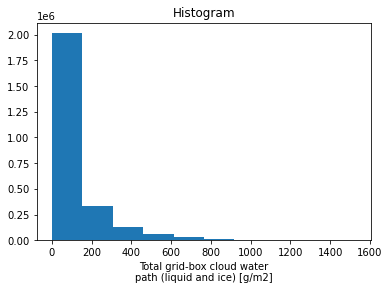

In [18]:
ds_all['TGCLDCWP'].plot()

In [19]:
import numpy as np

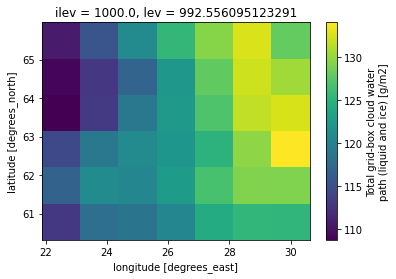

In [20]:
ds_all['TGCLDCWP_incld'].where(ds_all['CLDFREE']<.99).mean('time').plot()

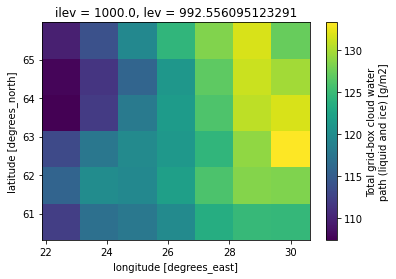

In [21]:
ds_all['TGCLDCWP_incld'].mean('time').plot()

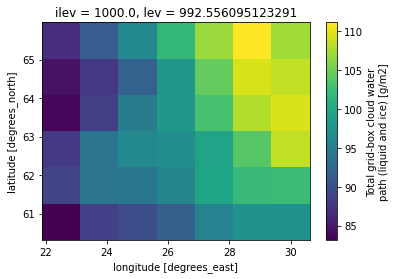

In [22]:
ds_all['TGCLDCWP'].mean('time').plot()

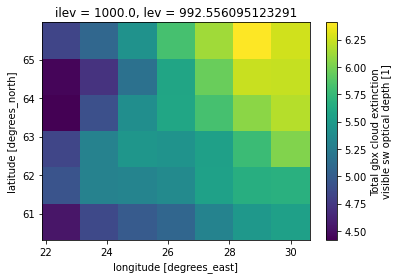

In [23]:
ds_all['TOT_CLD_VISTAU_s'].mean('time').plot()

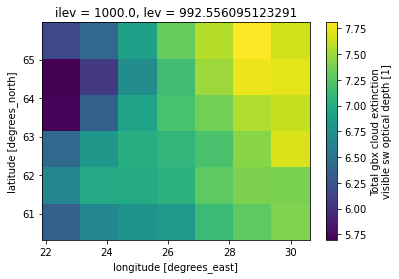

In [24]:
ds_all['TOT_CLD_VISTAU_s_incld'].mean('time').plot()

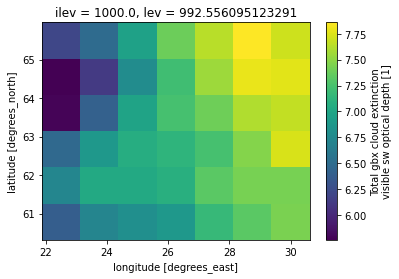

In [25]:
ds_all['TOT_CLD_VISTAU_s_incld'].where(ds_all['CLDFREE']<.99).mean('time').plot()

### Finally produce daily median dataframe:

In [27]:
dic_ds = dict()
dic_ds[case_name] =ds_all

In [28]:
from timeit import default_timer as timer



In [30]:
if not fn_comb_lev1_final_csv.exists():
    start = timer()
    for key in dic_ds:
        dic_ds[key] = dic_ds[key].rename(rn_dic_noresm_cloud)

    dic_df = get_dic_df_mod(dic_ds, select_hours_clouds=True, summer_months=[7,8])

    df_mod = dic_df[case_name]
    df_mod.to_csv(fn_comb_lev1_final_csv)
    end = timer()
    print(end - start) # Time in seconds, e.g. 5.38091952400282
    print(f'DONE! That took {(end-start)} seconds')    
    print(f'That is  {((end-start)/60)} minuts')

<xarray.Dataset>
Dimensions:            (time: 61344, lat: 6, lon: 7)
Coordinates:
    ilev               float64 ...
  * lat                (lat) float64 60.79 61.73 62.67 63.61 64.55 65.5
    lev                float64 ...
  * lon                (lon) float64 22.5 23.75 25.0 26.25 27.5 28.75 30.0
  * time               (time) datetime64[ns] 2012-01-02 ... 2018-12-31T23:00:00
Data variables: (12/193)
    NMR13              (time, lat, lon) float32 ...
    nscur              (time) int32 ...
    hybm               (time) float64 ...
    T                  (time, lat, lon) float32 ...
    EC550AER           (time, lat, lon) float32 ...
    FLNS               (time, lat, lon) float32 ...
    ...                 ...
    OAG                (time, lat, lon) float64 ...
    OA                 (time, lat, lon) float64 ...
    POA                (time, lat, lon) float64 ...
    SO4                (time, lat, lon) float64 ...
    optical_depth      (time, lat, lon) float32 ...
    transmittance

## ECHAM-SALSA

### Names etc

In [31]:

case_name = 'SALSA_BSOA_feedback'
case_name_echam = 'SALSA_BSOA_feedback'
time_res = 'hour'
space_res='locations'
model_name='ECHAM-SALSA'
model_name_echam  ='ECHAM-SALSA'

### Input path:

In [32]:
input_path_echam = path_extract_latlon_outdata / model_name_echam / case_name_echam 

In [33]:

cases_echam = [case_name_echam]

### Station variables  and others

In [34]:
varl_st_echam = [
    'mmrtrN500',
    'mmrtrN250',
    'mmrtrN200',
    'mmrtrN100',
    'mmrtrN50',
    'mmrtrN3',
    'SO2_gas',
    'APIN_gas',
    'TBETAOCI_gas',
    'BPIN_gas',
    'LIMON_gas',
    'SABIN_gas',
    'MYRC_gas',
    'CARENE3_gas',
    'ISOP_gas',
    'VBS0_gas',
    'V*BS1_gas',
    'VBS10_gas',
    'ORG_mass',
    'oh_con',
    'tempair',
    'ccn02',
    'ccn10',
]


varl_cl_echam = [
    'airdens',
    'uw',
    'vw',
    'cod',
    'cwp',
    'ceff',
    'ceff_ct',
    'lcdnc',
    'lcdnc_ct',
    'clfr',
    'cl_time',
    'aot550nm',
    'up_sw',
    'up_sw_cs',
    'up_sw_noa',
    'up_sw_cs_noa',
    'up_lw',
    'up_lw_cs',
    'up_lw_noa',
    'up_lw_cs_noa',
    'emi_monot_bio',
    'emi_isop_bio',
           ]

### Define some strings for files

In [35]:

str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')
str_lonlim = '%.1f-%.1f'%(*lon_lims,)
str_latlim = '%.1f-%.1f'%(*lat_lims,)
str_coordlims = f'{str_lonlim}_{str_latlim}'
str_coordlims

'22.0-30.0_60.0-66.0'

### Filenames: 

In [36]:
fn_final_echam = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_echam_csv = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.csv'

In [37]:
fn_final_echam

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/ECHAM-SALSA/SALSA_BSOA_feedback/SALSA_BSOA_feedback_2012-01-01-2019-01-01_ALL-VARS_concat_subs_22.0-30.0_60.0-66.0.nc')

### Open data

In [38]:
fl_open = []

for v in varl_cl_echam+ varl_st_echam:
    fn = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_{v}_concat_subs_{str_coordlims}.nc'
    if fn.exists():
        fl_open.append(fn)

In [39]:
len(fl_open)

29

### Open files, decode time, drop excess coords, select bottom layer, broadcast station vars to whole grid and compute units etc

In [40]:
if not fn_final_echam.exists():
    ds_all = xr.open_mfdataset(fl_open, decode_cf = False)
    #ds_iso = xr.open_dataset(fl_open[21])
    #ds = xr.merge([ds_iso,ds])
    ds_all = import_fields_xr_echam.decode_cf_echam(ds_all)
    ds_all = extract_2D_cloud_time_echam(ds_all) 
    
    #ds_sel = ds_all.sel(lat = lat_smr, lon= lon_smr, method='nearest').isel( lev=model_lev_i)#.load()
    ds_all = ds_all.squeeze()
    
    ds_all=ds_all.drop(['hyai','hybi','hyam','hybm']).squeeze()
    ds_all = ds_all.isel( lev=model_lev_i)
    

    ds_all = broadcase_station_data(ds_all, varl_st=varl_st_echam)
    

    ds_all = change_units_and_compute_vars_echam(ds_all)
    delayed_obj = ds_all.to_netcdf(fn_final_echam, compute=False)
    print('hey')
    with ProgressBar():
        results = delayed_obj.compute()

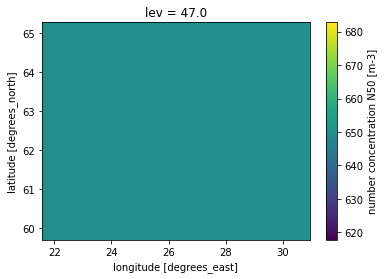

In [41]:
ds_all = xr.open_dataset(fn_final_echam)
ds_all['N50'].mean('time').plot()#.isel(lat=0, time=0).plot()#.shape#.plot()

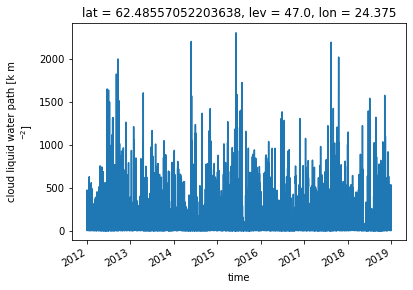

In [42]:
ds_all['cwp'].isel(lat=1, lon=1).plot()

### Fix time for echam

### Finally produce daily median dataframe:

In [43]:
rn_dic_echam_cloud

{'cwp_incld': 'CWP', 'cod_incld': 'COT', 'ceff_ct_incld': 'r_eff'}

In [44]:
rn_dic_echam_cloud

{'cwp_incld': 'CWP', 'cod_incld': 'COT', 'ceff_ct_incld': 'r_eff'}

In [45]:
dic_ds = dict()
dic_ds[case_name] =ds_all

In [46]:
if not fn_final_echam_csv.exists():
    for key in dic_ds:
        dic_ds[key] = dic_ds[key].rename(rn_dic_echam_cloud)

        dic_df = get_dic_df_mod(dic_ds, select_hours_clouds=True, summer_months=[7,8])

    df_mod = dic_df[case_name]
    df_mod.to_csv(fn_final_echam_csv)

<xarray.Dataset>
Dimensions:           (time: 61368, lat: 3, lon: 5)
Coordinates:
  * lat               (lat) float64 64.35 62.49 60.62
    lev               float64 ...
  * lon               (lon) float64 22.5 24.38 26.25 28.12 30.0
  * time              (time) datetime64[ns] 2012-01-01T00:52:30 ... 2018-12-3...
Data variables: (12/45)
    ORG_mass          (time, lat, lon) float32 ...
    airdens           (time, lat, lon) float32 ...
    aot550nm          (time, lat, lon) float32 ...
    ccn02             (time, lat, lon) float32 ...
    ccn10             (time, lat, lon) float32 ...
    ceff              (time, lat, lon) float32 ...
    ...                ...
    N200              (time, lat, lon) float32 ...
    OA                (time, lat, lon) float32 ...
    cwp               (time, lat, lon) float32 ...
    CWP               (time, lat, lon) float32 ...
    lcdnc_cm3         (time, lat, lon) float32 ...
    T_C               (time, lat, lon) float32 ...
Attributes:
    CDI:  

In [47]:
fn_comb_lev1_final_csv#.exists()

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/OsloAero_intBVOC_f09_f09_mg17_fssp245/OsloAero_intBVOC_f09_f09_mg17_fssp245.h1._2012-01-01-2019-01-01_concat_subs_22.0-30.0_60.0-66.0_lev1_final.csv')

In [48]:
_df = pd.read_csv(fn_comb_lev1_final_csv, index_col=0)#[_df['isSummer'].notnull()]

In [49]:
_df = _df[_df['isSummer'].notnull()]

In [50]:
pd.to_datetime(_df.index).month.unique()

Int64Index([7, 8], dtype='int64', name='time')

In [49]:
fn_final_echam_csv

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/ECHAM-SALSA/SALSA_BSOA_feedback/SALSA_BSOA_feedback_2012-01-01-2019-01-01_ALL-VARS_concat_subs_22.0-30.0_60.0-66.0.csv')